This notebook takes borehole data from the East Kimberley, interpolates/ averages the data so that it they can be formulated as a sample vs feature array. This array can be used to investigate correlations between datasets, impute the array  and be used as training data for interpretations at boreholes

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import fiona
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None



In [4]:
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp"

shape = fiona.open(infile)

#first feature of the shapefile
for i in range(4):
    shp = shape.next()
    if shp['properties']['Name'] == "Wider_Keep":
        OrdKeep = Polygon(shp['geometry']['coordinates'][0])

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  import sys


In [5]:
OrdKeep.wkt

'POLYGON ((516724.494422166 8344927.734538727, 563885.9317604062 8338362.33722946, 563776.5084719184 8338362.33722946, 504469.0861115328 8262641.421595905, 500420.4244374844 8263079.114749855, 475909.607816218 8290653.783448781, 516724.494422166 8344927.734538727))'

In [6]:
# Extract data from the database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()


In [7]:
df_header = borehole_utils.extract_boreholes_within_geometry('borehole', connection, OrdKeep.wkt,
                                                             columns = 'all', verbose = True)



Select b.* from borehole b  where within(b.geom,GeomFromText('POLYGON ((516724.494422166 8344927.734538727, 563885.9317604062 8338362.33722946, 563776.5084719184 8338362.33722946, 504469.0861115328 8262641.421595905, 500420.4244374844 8263079.114749855, 475909.607816218 8290653.783448781, 516724.494422166 8344927.734538727))'));


In [8]:
df_header.columns

Index(['borehole_id', 'Borehole_name', 'Alternative_name', 'Easting',
       'Northing', 'Ground_elevation_mAHD', 'Induction_acquired',
       'Gamma_acquired', 'Javelin_acquired', 'Hylogger_acquired_on_core',
       'Hylogger_acquired_on_chips', 'Lithology_available', 'EC_pH_acquired',
       'SWL_available', 'Construction_available', 'MagSus_available',
       'AEM_conductivity_available', 'geometry'],
      dtype='object')

utm_zone = 52
51 points in UTM bounding box: [481885.0, 8274026.4, 542732.935, 8333350.0]


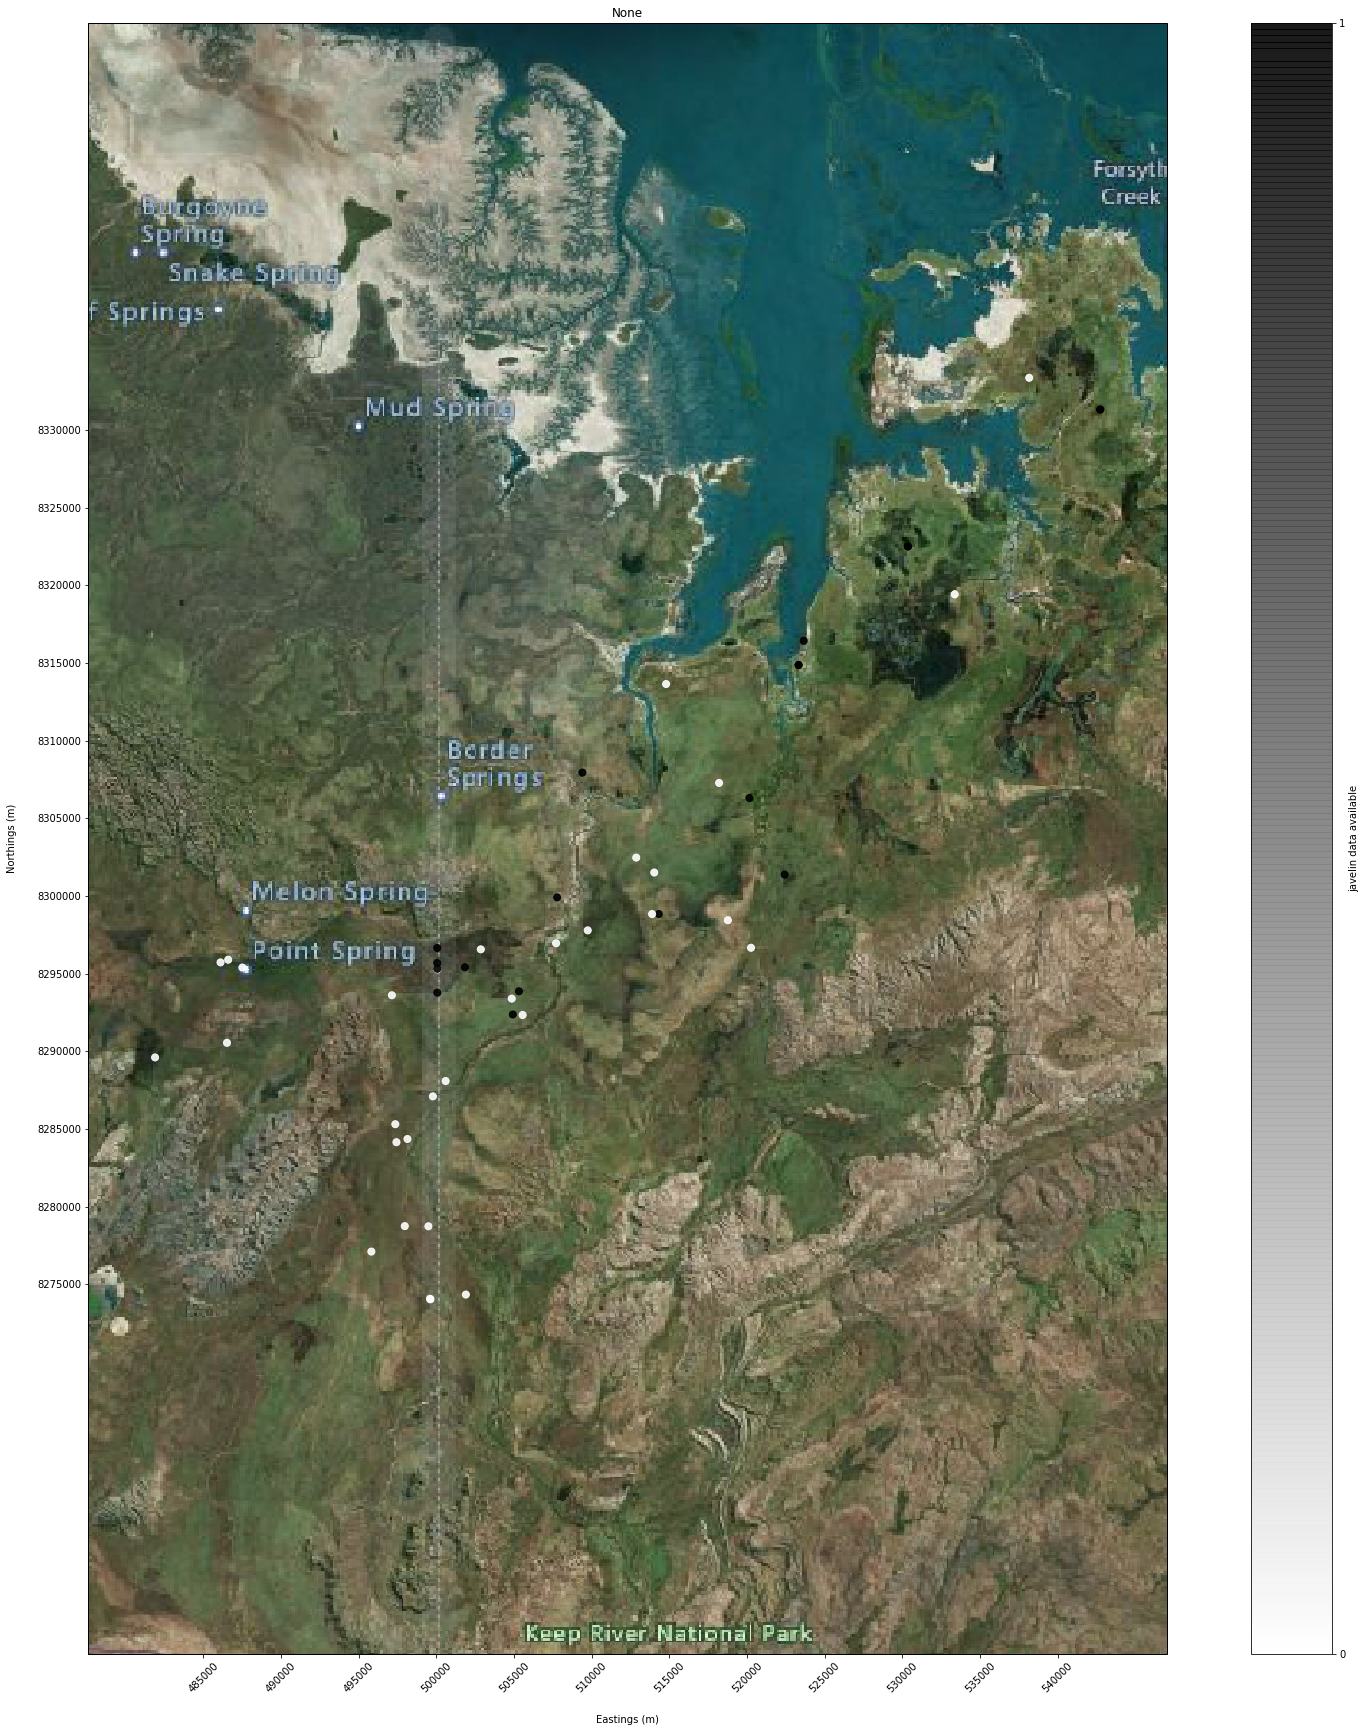

In [9]:
# Plot the bores on a basemap to get an idea of what datasets are available

utm_coords = df_header[['Easting', 'Northing']].values

# For example do we have javelin available
javelin_acquired = df_header['Javelin_acquired'].values

plotting_utils.plot_point_dataset(utm_coords, "EPSG:28352", javelin_acquired, 
                   colourbar_label = 'javelin data available', 
                    point_size=50)


In [15]:
# First import all the datasets based on our enos (primary key)

enos = df_header.borehole_id.values


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)

df_lithology = borehole_utils.extract_sql_with_primary_key("borehole_lithology", ['Depth_from', 'Depth_to',
                                                'Lithology_type',
                                                           'borehole_id'], connection, enos,
                                                          verbose = True)


# Classify the lithology using a yaml file keyword lookup table
yaml_file = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\classification\hydclass_classification.yml"

with open(yaml_file) as f:
    # use safe_load instead load
    hyd_class = yaml.safe_load(f)


# Assign all rows to a class of 7 which is the unkown class
df_lithology['hydraulic_class'] = 7

# iterate through lithology names
for index, row in df_lithology.iterrows():
    lithname = row.Lithology_type
    
    # Add the classification integer to the dataframe if it is found
    interval_class = search(hyd_class, lithname)
    
    if interval_class is not None:
        df_lithology.at[index, 'hydraulic_class'] = interval_class
    else:
        # Otherwise we can add it to the yaml file
        print(lithname)
    
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','Gamma_calibrated',
                                                         'GR','borehole_id'], connection, enos,
                                                       verbose = True)

df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos, verbose = True)


select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635921,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,636204,636205);
select t.Depth_from, t.Depth_to, t.Lithology_type, t.borehole_id from borehole_lithology t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635921,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636189,636190,636191,636193,636194,636195,636196,636197,636198,636200,636201,63

In [16]:
# Our first investigation will be looking at relationships between these borehole data 
# and the AEM

# load AEM

nc_dir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf"

ek_cond = netCDF4.Dataset(os.path.join(nc_dir, "OrdKeep2019_ModeExp_cor2DLogOrd.nc"))

# Create an instance of point utils

cond_point_util = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_util.utm_coords(cond_point_util.xycoords)

In [17]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 1 km of an AEM fiducial

distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                        points_required = 10, max_distance = 1000.)

In [18]:
# Here we will create a table of AEM conductivity profiles for each
# borehole. To guard against anomolous points we will take an inverse
# distance weighting of conductivity from the 10 closest points

# REsults are written into a dataframe

df_conductivity = pd.DataFrame(columns = {'borehole_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity'})

# Create a flag for if there is AEM data for the borehole

df_header['AEM_proximal'] = 0

for i, (index, row) in enumerate(df_header.iterrows()):
    # If the distances are not infinite (i.e. the boreholes disatnce is greater
    # than the maximum)
    if np.isfinite(np.sum(distances[i])):
        
        # Extract a representative profile
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                   distances[i], indices[i],
                                                   as_dataframe = True,
                                                  mask_below_doi=True)
        
        df_conductivity_profile['borehole_id'] = row.borehole_id

        # Append it to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile)
        
        # Update the flag
        df_header.at[index, 'AEM_proximal'] = 1 


C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [19]:
# Spit out this as a csv

outfile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\AEM\borhole_interpolated_AEM_profiles.csv"

df_conductivity.to_csv(outfile, index=False)

KeyError: 'Conductivity'

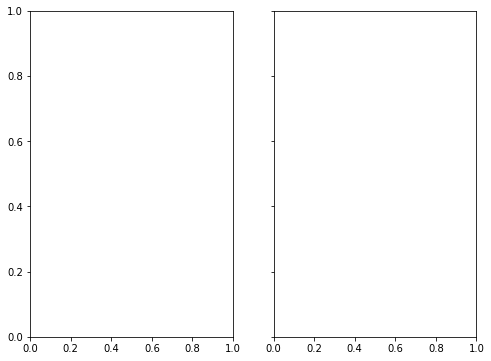

In [20]:
# Lets do a quick visual analysis of borehole induction vs AEM for outrsites

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\AEM_vs_induction_plots"

for index, row in df_header.iterrows():
    
    if (row['AEM_proximal'] == 1) & (row['Induction_acquired'] == 1):
        
        fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,6))
        
        # Extract the data using eno
        
        eno = row['borehole_id']
        
        
        # Extract induction
        
        indmask = df_indgam['borehole_id'] == eno
        
        induction_profile = df_indgam[indmask]['Conductivity'].values
        
        depth = df_indgam[indmask]['Depth'].values
        
        ax2 = plotting_utils.plot_downhole_log(ax2, induction_profile,
                                  depth,log_plot=True)
        
        # Extract AEM conductivity
        condmask = df_conductivity['borehole_id'] == eno
        
        conductivity_profile = df_conductivity[condmask]['conductivity'].values
        
        depth_top= df_conductivity[condmask]['Depth_from'].values
        
        
        # So the plots are on a similar scale we clip the conductivity to
        # the depth of the bore + 20 m
        
        depth_mask = depth_top < (np.max(depth) + 20.) 
        
        ax1 = plotting_utils.plot_1D_layered_model(ax1, conductivity_profile[depth_mask],
                                  depth_top[depth_mask], doi=None, log_plot=True)
        
        
        ax1.set_title("AEM inverted model")
        ax1.set_ylabel("Depth")
        ax1.set_xlabel("AEM bulk Conductivity (S/m)")
        ax2.set_title("Borehole induction data")

        ax2.set_xlabel("borehole induction conductivity (S/m)")
        #plt.savefig(os.path.join(outdir, row['Borehole_name'] + "_conductivity_vs_induction.png"))
        
        # We plot a pretty example
        if index == df_header[df_header['Borehole_name'] == 'RN040310'].index:
            plt.show()
        
        plt.close()
        

In [22]:
# Now lets try interpolating all data onto the lithology intervals

df_subset = df_header[df_header['Lithology_available'] == 1]

# The data will be appended to a dataframe called interpolated

df_interpolated = pd.DataFrame(columns = ['Depth_from', 'Depth_to', 'hydraulic_class',
                                         'AEM_conductivity', 'Induction', 'GR',
                                          "Gamma_calibrated", "EC", 'pH'])

# Iterate through the bores

for index, row in df_subset.iterrows():
    
    # First we want to find the min and max depth for the boreholes
    eno = row.borehole_id
    
    df_lith_subset = borehole_utils.extract_by_primary_key(df_lithology, eno)[['Depth_from',
                                                                              'Depth_to',
                                                                              'borehole_id',
                                                                              'hydraulic_class']]
    
    intervals = df_lith_subset[["Depth_from",
                                "Depth_to"]]
    
    hydraulic_class = df_lith_subset['hydraulic_class']
    
    # Now we interpolate the layered AEM model on these intervals if the data exists
    
    if row.AEM_proximal:
        
        df_cond_subset = borehole_utils.extract_by_primary_key(df_conductivity,
                                                           eno)
        # Define variable column name(s)
        cols = ['conductivity']
        # Interpolate
        df_newcond = spatial_functions.interpolate_layered_model(df_cond_subset,
                                                                 cols,
                                                                 ["Depth_from",
                                                                  "Depth_to"],
                                                                  intervals)
        # Add as a new column to the lith subset frame
        df_lith_subset[cols] = df_newcond[cols]
    
    # Subset the induction and gamma data
    
    # The exact way of dealing with the variable data coverage will be subset specific
    # Some bore will have on 
    if (row.Induction_acquired) or (row.Gamma_acquired):
        
        df_indgam_subset = borehole_utils.extract_by_primary_key(df_indgam,
                                                           eno)
        
        # Define variable column name(s)
        cols = ['Apparent_conductivity','GR', "Gamma_calibrated"]
        # Interpolate this time using the point depth to interval fucntion
        df_newindgam = spatial_functions.interpolate_depths_to_intervals(df_indgam_subset,
                                                                         cols,
                                                                        intervals)
        
        # Add as a new column to the lith subset frame
        df_lith_subset[cols] = df_newindgam[cols]
    
    # EC and pH
    if row.EC_pH_acquired:
        
        df_ECpH_subset = borehole_utils.extract_by_primary_key(df_EC_pH,
                                                           eno)
        
        # Define variable column name(s)
        cols = ['EC', "pH"]
        
        # Interpolate this time using the point depth to interval fucntion
        df_newECpH = spatial_functions.interpolate_depths_to_intervals(df_ECpH_subset,
                                                                         cols,
                                                                         intervals)
        # Add as a new column to the lith subset frame
        df_lith_subset[cols] = df_newECpH[cols]
    
    # Borehole NMR
    if row.Javelin_acquired:
        
        df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Free_water_content', 'Clay_water_content']
        # Interpolate
        df_newbNMR = spatial_functions.interpolate_depths_to_intervals(df_bNMR_subset,
                                                                         cols,
                                                                         intervals)
        # Add as a new column to the lith subset frame
        df_lith_subset[cols] = df_newbNMR[cols]
    
    # Do some renaming of columns
    df_lith_subset.rename(columns = {'conductivity': 'AEM_conductivity',
                                    'Conductivity': "Induction"}, inplace = True)
    
    # Append to dataframe
    df_interpolated = df_interpolated.append(df_lith_subset)
        
        
# Remove any columns without any entries

df_interpolated.dropna(axis = 1, how = 'all', inplace = True)
    

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\spatial_functions.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  new_intervals[p] = np.nan


ValueError: Columns must be same length as key

In [24]:
df_indgam_subset

,Depth,Apparent_conductivity,Gamma_calibrated,GR,borehole_id
20293,0.289,NaN,NaN,41.45691,635728
20294,0.339,NaN,NaN,43.53450,635728
20295,0.389,NaN,NaN,45.60826,635728
20296,0.439,NaN,NaN,47.43258,635728
20297,0.489,NaN,NaN,48.91601,635728
20298,0.539,NaN,NaN,50.17364,635728
20299,0.589,NaN,NaN,51.07046,635728
20300,0.639,NaN,NaN,51.71267,635728
20301,0.689,NaN,NaN,52.55183,635728
20302,0.739,NaN,NaN,53.33330,635728


In [47]:
df_header

,borehole_id,Borehole_name,Easting,Northing,Ground_elevation_mAHD,Induction_acquired,Gamma_acquired,Javelin_acquired,Hylogger_acquired_on_core,Hylogger_acquired_on_chips,Lithology_available,EC_pH_acquired,SWL_available,geometry,AEM_proximal
0,621622,17BP01I,478993.383,8335027.204,41.750,1,1,1,0,0,0,0,1,POINT (478993.383 8335027.204),0
1,621623,17BP03I,469012.153,8340498.650,109.525,1,1,1,0,0,0,0,1,POINT (469012.153 8340498.65),0
2,626981,RN029663,509738.000,8297777.000,14.936,1,1,0,0,0,0,0,1,POINT (509738 8297777),1
3,626984,RN034821,514784.000,8313635.000,12.281,1,1,0,0,0,0,0,1,POINT (514784 8313635),1
4,626986,RN029660,500047.884,8295266.378,19.217,1,1,0,0,0,0,0,1,POINT (500047.884 8295266.378),1
5,626987,RN029665,512860.000,8302461.000,11.873,1,1,0,0,0,0,0,1,POINT (512860 8302461),1
6,626988,RN029653,514021.000,8301501.000,12.904,1,1,0,0,0,0,0,1,POINT (514021 8301501),1
7,626989,RN029656,504845.000,8293381.000,17.650,1,1,0,0,0,0,0,1,POINT (504845 8293381),1
8,626990,RN029666,518194.000,8307268.000,9.266,1,1,0,0,0,0,0,1,POINT (518194 8307268),1
9,626991,RN029662,500590.000,8288080.000,18.952,1,1,0,0,0,0,0,1,POINT (500590 8288080),1


In [52]:
df_interpolated_ = df_interpolated.merge(df_header[['Easting','Northing', 'Ground_elevation_mAHD',
                                                    'borehole_id']], on = 'borehole_id')

In [57]:
df_interpolated_.to_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Data_Fusion\Datasets\EK_testbed\lith.csv")

In [51]:
df_header.columns

Index(['borehole_id', 'Borehole_name', 'Easting', 'Northing',
       'Ground_elevation_mAHD', 'Induction_acquired', 'Gamma_acquired',
       'Javelin_acquired', 'Hylogger_acquired_on_core',
       'Hylogger_acquired_on_chips', 'Lithology_available', 'EC_pH_acquired',
       'SWL_available', 'geometry', 'AEM_proximal'],
      dtype='object')

In [54]:
df_interpolated_['Elevation'] = df_interpolated_['Ground_elevation_mAHD'] - (df_interpolated_['Depth_to'] - 0.5*(df_interpolated_['Depth_to'] - df_interpolated_['Depth_from']))